In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os, sys

import tensorflow as tf

from tqdm import tqdm

- https://datascientest.com/quest-ce-que-le-modele-vgg
- https://keras.io/api/applications/vgg/#vgg16-function
- https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4
- https://github.com/gabrielcassimiro17/object-detection/blob/main/transfer_learning.ipynb

#### Partie 1: Base de données, analyse et préparation

In [2]:
directory = './Mask_Data/'

images = []
labels = []

for i in os.listdir(directory):
    Path = directory+"/"+i
    
    for j in os.listdir(Path):
        image = cv2.imread(Path+"/"+j)
        image = cv2.resize(image, (224,224))
        images.append(image)
        if i == 'without_mask':
            labels.append(0)
        else:
            labels.append(1)
        #labels.append(str(i))
        
images = np.array(images)   
images.shape

(1508, 224, 224, 3)

In [3]:
labels = np.array(labels)

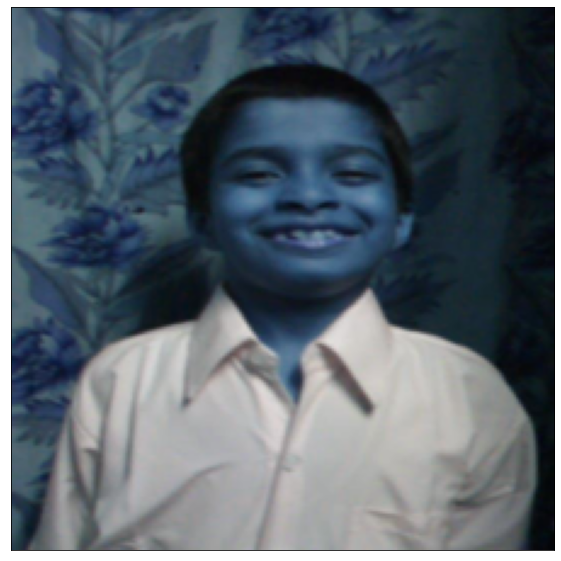

In [4]:
class_names = ['without_mask', 'with_mask']

plt.figure(figsize=(10,10))

waiwai = np.random.randint(0,1000,[1])
plt.subplot()
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(images[waiwai[0]])
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = 0)

#### Partie 2 Architecture CNN sur tensorflow

In [6]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

import keras
from keras.layers import Dense, Flatten
from keras.models import Model, Sequential
from keras import backend as K
from keras.applications.vgg16 import VGG16

# générer les paramètres de l'augmentation des photos
augmentation = ImageDataGenerator(
        rotation_range = 10,
        fill_mode="nearest",
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        zoom_range = 1.1,
        horizontal_flip = True
        )




# Modèle VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 
# Freezer les couches du VGG16
for layer in base_model.layers: 
    layer.trainable = False

# Initialisation du modèle
model = Sequential()
model.add(base_model) # Ajout du modèle VGG16
model.add(Flatten()) 
model.add(Dense(4096,activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 2)                 8194      
                                                                 
Total params: 134,268,738
Trainable params: 119,554,050
Non-trainable params: 14,714,688
_________________________________________________________________


In [8]:
print(X_train.shape)
print(X_test.shape)

(1206, 224, 224, 3)
(302, 224, 224, 3)


In [9]:
y_train = tf.keras.utils.to_categorical(y_train, 2) #Converts a class vector (integers) to binary class matrix
y_test_categorical = tf.keras.utils.to_categorical(y_test, 2)#Converts a class vector (integers) to binary class matrix


model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# fonction callback pour sauvegarde du modèle
filepath = "./16_BRIEF_Detection_Masques_VGG16_Neurones"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_model_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


# arrêter entraînement si bon modèle
stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


# entraînement du modèle
history = model.fit(
    augmentation.flow(X_train, y_train),
    validation_data=(X_test, y_test_categorical),
    epochs=4,
    callbacks=[model_checkpoint_callback, stop])

Epoch 1/4


C:\Users\utilisateur\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


38/38 [==============================] - 494s 13s/step - loss: 24.0400 - accuracy: 0.7778 - val_loss: 0.1188 - val_accuracy: 0.9735
Epoch 2/4
38/38 [==============================] - 459s 12s/step - loss: 0.3349 - accuracy: 0.8955 - val_loss: 0.0209 - val_accuracy: 0.9934
Epoch 3/4
38/38 [==============================] - 449s 12s/step - loss: 0.2459 - accuracy: 0.9080 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 4/4
38/38 [==============================] - 440s 12s/step - loss: 0.2434 - accuracy: 0.9129 - val_loss: 0.0045 - val_accuracy: 0.9967


Evaluer le modèle

10/10 - 84s - loss: 0.0045 - accuracy: 0.9967 - 84s/epoch - 8s/step


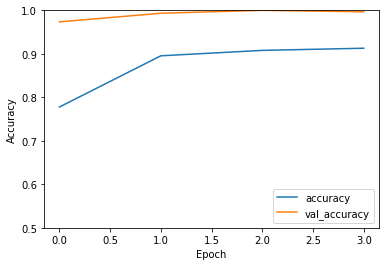

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test_categorical, verbose=2)

In [11]:
# Sauvegarder le modèle
model.save('./mod.h5')

In [12]:
print(test_acc)

0.996688723564148


<AxesSubplot:>

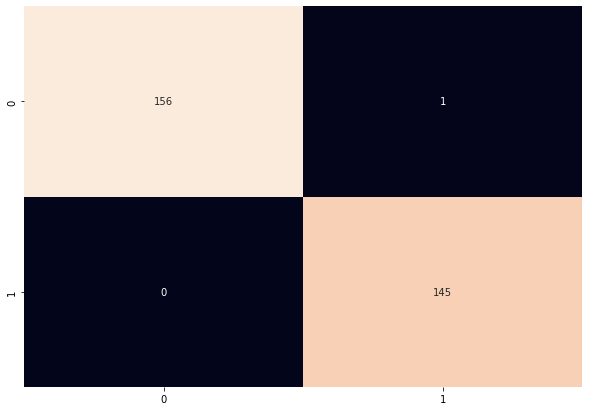

In [13]:
matrix= tf.math.confusion_matrix(
    y_test,
    np.argmax(model.predict(X_test), axis=-1),
    num_classes=2,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)
import seaborn as sns

plt.figure(figsize = (10,7))
sns.heatmap(matrix, annot=True, cbar=False, fmt="d", cmap="rocket")

#### Partie 3: Application du modèle

Tester l'efficacité du modèle
- si argmax = 0 (sans masque)
- si argmax = 1 (avec masque)

In [14]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [15]:
def aff_masque_ou_pas(OK):
    if (np.argmax(model.predict(OK)))== 0:
        print("SANS MASQUE")
    else:
        print("AVEC MASQUE")

In [16]:
OK = cv2.imread('./images_manuelles/nomasque00.jpg')
OK = cv2.resize(OK, (224,224))
OK= np.expand_dims(OK,axis=0)

print(OK.shape)
print("=================================================")
aff_masque_ou_pas(OK)
print("=================================================")
print(np.argmax(model.predict(OK)))
print("=================================================")
print(probability_model.predict(OK))

(1, 224, 224, 3)
SANS MASQUE
0
[[0.7310586  0.26894143]]


In [17]:
OK = cv2.imread('./images_manuelles/nomasque01.jpg')
OK = cv2.resize(OK, (224,224))
OK= np.expand_dims(OK,axis=0)

print(OK.shape)
print("=================================================")
aff_masque_ou_pas(OK)
print("=================================================")
print(np.argmax(model.predict(OK)))
print("=================================================")
print(probability_model.predict(OK))

(1, 224, 224, 3)
SANS MASQUE
0
[[0.73105854 0.2689415 ]]


In [18]:
OK = cv2.imread('./images_manuelles/masque00.jpg')
OK = cv2.resize(OK, (224,224))
OK= np.expand_dims(OK,axis=0)

print(OK.shape)
print("=================================================")
aff_masque_ou_pas(OK)
print("=================================================")
print(np.argmax(model.predict(OK)))
print("=================================================")
print(probability_model.predict(OK))

(1, 224, 224, 3)
AVEC MASQUE
1
[[0.26894143 0.7310586 ]]


In [19]:
OK = cv2.imread('./images_manuelles/masque01.jpg')
OK = cv2.resize(OK, (224,224))
OK= np.expand_dims(OK,axis=0)

print(OK.shape)
print("=================================================")
aff_masque_ou_pas(OK)
print("=================================================")
print(np.argmax(model.predict(OK)))
print("=================================================")
print(probability_model.predict(OK))

(1, 224, 224, 3)
AVEC MASQUE
1
[[0.26894537 0.73105466]]


Application du modèle en direct via camera

In [20]:
import cv2
import os
import numpy as np
import tensorflow as tf
import keras


#Chargement du modèle permettant de détecter le port du masque
modelMasque = keras.models.load_model("./mod.h5")

#Capture de la caméra (idCamera)
cap = cv2.VideoCapture(0)

while True:
   
    _, image = cap.read()

    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    

    #Appel du modèle appris pour la detection de masque
    capture = cv2.resize(image, (224, 224))
    capture = capture.reshape((1, capture.shape[0], capture.shape[1], capture.shape[2]))
    predict = modelMasque.predict(capture)
    print(predict)
    pasDeMasque = predict[0][0]
    avecMasque = predict[0][1]

    # Interpretation de la prediction
    if (pasDeMasque > avecMasque):
        # cv2.rectangle(image, (startX, startY), (endX, endY),(0, 0, 255), 2)
        cv2.putText(image, "PAS DE MASQUE", (100, 100),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    else:
        # cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)
        cv2.putText(image, "OK", (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 255), 2)


    # Affichage de l'image
    cv2.imshow('img', image)
    
    # touche de sortie du programme (q)
    if (cv2.waitKey(30) & 0xff) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
